In [1]:
%pip install git+https://github.com/coax-dev/coax.git@main --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext tensorboard
%tensorboard --logdir ./data/tensorboard

Reusing TensorBoard on port 6006 (pid 7084), started 0:03:18 ago. (Use '!kill 7084' to kill it.)

In [3]:
# Run this cell to fix rendering errors.
import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'

In [4]:
!pip install shutup
##At the top of the code
import shutup;
shutup.please()

In [5]:
pip install coax --upgrade

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gymnasium
import jax
import coax
import haiku as hk
import jax.numpy as jnp
from numpy import prod
import optax
import time


# the name of this script
name = 'sac'

# the Pendulum MDP
env = gymnasium.make('Pendulum-v1', render_mode='rgb_array')
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}")


def func_pi(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape) * 2, w_init=jnp.zeros),
        hk.Reshape((*env.action_space.shape, 2)),
    ))
    x = seq(S)
    mu, logvar = x[..., 0], x[..., 1]
    return {'mu': mu, 'logvar': logvar}


def func_q(S, A, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    X = jnp.concatenate((S, A), axis=-1)
    return seq(X)


# main function approximators
pi = coax.Policy(func_pi, env)
q1 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)
q2 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)

# target network
q1_targ = q1.copy()
q2_targ = q2.copy()

# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9, record_extra_info=True)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=25000)
alpha = 0.2
policy_regularizer = coax.regularizers.NStepEntropyRegularizer(pi,
                                                               beta=alpha / tracer.n,
                                                               gamma=tracer.gamma,
                                                               n=[tracer.n])

# updaters (use current pi to update the q-functions and use sampled action in contrast to TD3)
qlearning1 = coax.td_learning.SoftClippedDoubleQLearning(
    q1, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
qlearning2 = coax.td_learning.SoftClippedDoubleQLearning(
    q2, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
soft_pg = coax.policy_objectives.SoftPG(pi, [q1_targ, q2_targ], optimizer=optax.adam(
    1e-3), regularizer=coax.regularizers.NStepEntropyRegularizer(pi,
                                                                 beta=alpha / tracer.n,
                                                                 gamma=tracer.gamma,
                                                                 n=jnp.arange(tracer.n)))

tracker=[0.,0.]
# train
while env.T < 1000000:
    s, info = env.reset()
    total_reward=0
    for t in range(200):#(env.spec.max_episode_steps):
        a = pi(s)
        s_next, r, done, truncated, info = env.step(a)

        # trace rewards and add transition to replay buffer
        tracer.add(s, a, r, done)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= 5000:
            transition_batch = buffer.sample(batch_size=128)

            # init metrics dict
            metrics = {}

            # flip a coin to decide which of the q-functions to update
            qlearning = qlearning1 if jax.random.bernoulli(q1.rng) else qlearning2
            metrics.update(qlearning.update(transition_batch))

            # delayed policy updates
            if env.T >= 7500 and env.T % 4 == 0:
                metrics.update(soft_pg.update(transition_batch))

            env.record_metrics(metrics)

            # sync target networks
            q1_targ.soft_update(q1, tau=0.001)
            q2_targ.soft_update(q2, tau=0.001)
        total_reward+=r
        if done or truncated:
            break

        s = s_next
    tracker.append([time.time(), total_reward])
    #generate an animated GIF to see what's going on
    if env.period(name='generate_gif', T_period=10000) and env.T > 5000:
        T = env.T - env.T % 10000  # round to 10000s
        coax.utils.generate_gif(
            env=env, policy=pi, filepath=f"./data/gifs/{name}/T{T:08d}.gif")


INFO:TrainMonitor:ep: 1,	T: 201,	G: -971,	avg_r: -4.86,	avg_G: -971,	t: 200,	dt: 4.995ms
INFO:TrainMonitor:ep: 2,	T: 402,	G: -1.61e+03,	avg_r: -8.06,	avg_G: -1.29e+03,	t: 200,	dt: 3.130ms
INFO:TrainMonitor:ep: 3,	T: 603,	G: -1.34e+03,	avg_r: -6.7,	avg_G: -1.31e+03,	t: 200,	dt: 2.175ms
INFO:TrainMonitor:ep: 4,	T: 804,	G: -1.67e+03,	avg_r: -8.36,	avg_G: -1.4e+03,	t: 200,	dt: 2.219ms
INFO:TrainMonitor:ep: 5,	T: 1,005,	G: -882,	avg_r: -4.41,	avg_G: -1.3e+03,	t: 200,	dt: 2.303ms
INFO:TrainMonitor:ep: 6,	T: 1,206,	G: -856,	avg_r: -4.28,	avg_G: -1.22e+03,	t: 200,	dt: 2.097ms
INFO:TrainMonitor:ep: 7,	T: 1,407,	G: -1.28e+03,	avg_r: -6.38,	avg_G: -1.23e+03,	t: 200,	dt: 2.153ms
INFO:TrainMonitor:ep: 8,	T: 1,608,	G: -1.44e+03,	avg_r: -7.21,	avg_G: -1.26e+03,	t: 200,	dt: 3.102ms
INFO:TrainMonitor:ep: 9,	T: 1,809,	G: -1.22e+03,	avg_r: -6.1,	avg_G: -1.25e+03,	t: 200,	dt: 4.146ms
INFO:TrainMonitor:ep: 10,	T: 2,010,	G: -1.3e+03,	avg_r: -6.51,	avg_G: -1.26e+03,	t: 200,	dt: 3.075ms
INFO:TrainMonitor:ep: 

[-4.32974733  3.43390969]
-4.07472279580695 0.06928462414246762 -4.075311794428909
-1.2129598986219927 0.6356023177237322 -1.369402067312904
-1.142732370281445 0.821903913564001 -1.407609076846576
-1.039497749408414 0.8899836888096514 -1.3684394533089115
-1.2527706184502503 0.9649448749886004 -1.581313641950574
-1.095127536155878 0.6273181021625407 -1.2620746102143312
-0.9518194185083404 0.9685437516229232 -1.357953314461643
-1.2902232803259364 0.6345273474838065 -1.4378112072869147
-1.1976309284048685 0.7383146476388387 -1.4069215897092382
-1.2062447261316822 0.8932422147529683 -1.5009690181803503
-1.1522039752839217 1.0037566554183939 -1.528103865565686
-1.2867808910392395 0.6774050716171429 -1.4541948606003137
-0.9859760618639 0.6238616479235849 -1.1667699646110952
-1.258166827913797 0.5617628654920443 -1.3778828992002545
-0.9420032333360431 0.7746057043224867 -1.219583571873816
-1.038646076789013 0.6009681329322899 -1.1999784871527202
-1.3939595046604842 0.5450062749902251 -1.49671

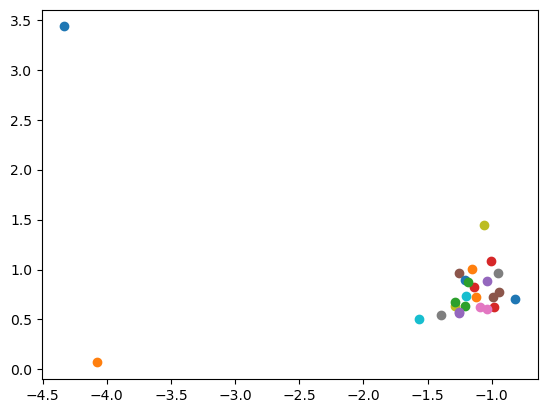

[-1.33225347  0.54605892]


In [8]:
#display for van der pol
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import gymnasium

env = gymnasium.make("VDP-v0")
observation, info = env.reset()
s=observation
#s=np.array([5.5,5.5])
x=s[0]
y=s[1]
print(s)
plt.figure(1)
plt.scatter(x,y)#,'ro')
for i in range(1000):
    a= pi(s)
    #a=np.array([0])
    obs, reward, terminated, truncated, info = env.step(a)
    s=obs
    x=s[0]
    y=s[1]
    if i % 20 ==0:  
        print(x,y,reward)
        plt.scatter(x, y)
    #print(reward)
    if (terminated or truncated):  break
env.close()
plt.show()
print(s)